# Lead Free Buffalo ML Model

## Data Preprocessing: Buffalo Data

This notebook records the procedure I used to preprocess the Buffalo data for my project [Lead Free Buffalo](https://leadfreebflo.com).

[Link to the raw data](https://investigativepost.carto.com/tables/buffalo_lead/public).

First, I downloaded the data in CSV format and loaded it into Pandas.

In [2]:
import pandas as pd
import numpy as np
import requests

import time
from joblib import Memory

%matplotlib inline

buffalo_lead = pd.read_csv('data/buffalo_lead.csv')
buffalo_lead.head()

,the_geom,cartodb_id,year,lead_ppb,address,zipcode,latitude,longitude
0,0101000020E610000053E9279CDDB353C0003B376DC66F...,1,2002,0.0,"45 Kopernik Buffalo, NY, 14206",14206,42.873243,-78.810401
1,0101000020E61000000ECAEA0CC2B853C09A362DC25E78...,2,2002,0.0,"95 Howell Buffalo, NY, 14207",14207,42.940392,-78.886844
2,0101000020E6100000B5A1629CBFB853C033A083D3277A...,3,2002,0.0,"106 Rebecca Buffalo, NY, 14207",14207,42.954340,-78.886695
3,0101000020E610000016342DB132B653C09949D40B3E75...,4,2002,0.0,"141 Butler Buffalo, NY, 14208",14208,42.915956,-78.846844
4,0101000020E610000017963FDF16B653C0D57B2AA73D75...,5,2002,0.0,"187 Butler Buffalo, NY, 14208",14208,42.915944,-78.845146


Here we split the address into a street number and a street name. For example, `"45 Kopernik Buffalo, NY, 14206"` would have `"Prop_Num_str" = 45` and `"PropStreet" = "Kopernik"`.

In [3]:
addr_segments = buffalo_lead['address'].str.split(expand=True)
buffalo_lead['Prop_Num_str'], buffalo_lead['PropStreet'] = addr_segments[0], addr_segments[1]

The variables we really care about are `latitude`, `longitude`, and `lead_ppb`. Looking at the histogram of lead data (`lead_ppb`), we see that there is a pretty substantial right skew, with the majority of the tests returning results below 5 parts per billion. The right skew is not surprising as this is a physical, measured quantity that must be greater than or equal to zero.

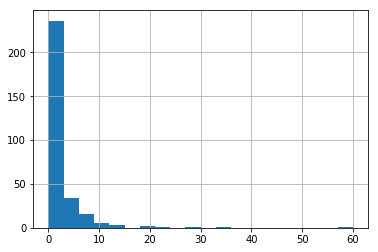

In [4]:
lead_hist = buffalo_lead['lead_ppb'].hist(bins = 20)

## Mapping

I did some basic map visualization that should be available shortly on my website (will edit with link). 
It is immediately clear how sparse and clustered the sampling is; there are large areas on the map that have not been sampled at all.

In [5]:
import folium

import branca.colormap as cm

max_lead = buffalo_lead['lead_ppb'].max()
min_lead = buffalo_lead['lead_ppb'].min()



buffalo_coord = [42.8864, -78.8784]


map_buffalo = folium.Map(location=buffalo_coord, zoom_start=12,tiles='cartodbpositron', width = 640, height=480)

for index, row in buffalo_lead.iterrows():
    shade = 'blue'
    if row['lead_ppb'] > 2.0:
        shade = 'red'
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=1, color=shade, fill_color=shade).add_to(map_buffalo)

map_buffalo.add_child(folium.LatLngPopup())

map_buffalo

## Next step: merging in housing data

The next step of the preprocessing involved getting housing data. Unlike Flint, Buffalo publishes their municipal data [on an open portal](https://data.buffalony.gov/). So it was a relatively simple task to query the [2018-2019 Assessment Roll](https://data.buffalony.gov/Government/2018-2019-Assessment-Roll/kckn-jafw) and grab the features I needed (`home age` and `property value` for each residence)

The `retrieve_assessment_data` function searches for matches to the properties based on matching street name `Prop_Num_str` and matching street number `PropStreet`. 

### joblib caching

We are using a public API provided by the City of Buffalo. Each call is relatively time consuming and repeating calls would waste time and computing resources. We elected to use joblib to cache a list of server responses on disk. The ` @memory.cache` decorator will return the cached responses if they are available on disk, so we can re-run that cell without re-running the time intensive and compute intensive task.

In [6]:
cachedir = '.'
memory = Memory(cachedir, verbose=0)

@memory.cache
def retrieve_assessment_data(df):
    responses = []
    for index, row in df.iterrows():
        r = requests.get('https://data.buffalony.gov/resource/kckn-jafw.json', {'hsenofr': row['Prop_Num_str'], 'street':row['PropStreet'].upper()})
        json_resp = r.json()
        responses.append(json_resp)
        time.sleep(0.5)
    return responses


Here we run the function we defined above, pulling the data from the server or from the cache. Once we have the list, we iterate through and access the `totalval` home value and `yrbuilt` home age data we require for our model.

In [7]:
assessment_data = retrieve_assessment_data(buffalo_lead)

In [8]:
data = {}

for index, assessment in enumerate(assessment_data):
    try:
        data[index] = {'SEV' : assessment[0]['totalval'], 'yearBuilt' : assessment[0]['yrblt'],
                       'lat' : assessment[0]['latitude'], 'lon' : assessment[0]['longitude']}
    except:
        pass

This approach worked well enough as a "first-pass" approach, but there were a few issues with our results. Of the 300 samples in Buffalo, we've only been able to get a home value and home age for 252 of them using this primary method. And once we start looking at distances, it's clear that some of our matches were not correct (some addresses are located kilometers away from their supposed locations - I'll go into this more in depth once we have the final dataframe.)

It's clear we'll need to use a more flexible approach to find and join the appropriate addresses.

The [2018-2019 Assessment Roll](https://data.buffalony.gov/Government/2018-2019-Assessment-Roll/kckn-jafw) is available for download, and I know that the [US Census Bureau maintains an online tool](https://geocoding.geo.census.gov/geocoder/locations/addressbatch?form) for processing addresses. It will take a bit of preprocessing and postprocessing to get this data, but it's a much more scalable solution and I hope it will ultimately get us better results! 

## Geocoding using the US Census Bureau tool

### Formatting the Lead Data

The Census Bureau tool requires a very specific input format, with house number and street name in one field, city in the next, then state, then 5-digit zip code. 

Here I put together a routine to split our addresses into the correct format. I made a mistake initially, if you are, be sure to cast the `ZIP CODE (5-DIGIT)` column to string before saving the CSV. Otherwise you will end up with `NON EXACT` matches because of a zero placeholder in the tenths place of the zip code. 

In [9]:
#Splitting address on commas, expand=True returns a dataframe
address_segs = buffalo_lead['address'].str.split(',', expand=True)
#This takes the first element ("45 Kopernik Buffalo" for example) and splits on spaces to get [45, Kopernik, Buffalo]
street_city = address_segs.loc[:,0].str.split()
#Here we join the house number and the street and put it one column, and then put the city in the next column
street_city_df = pd.DataFrame([[' '.join(val[:-1]), val[-1]] for val in street_city.tolist()])
#Finally we add in the state and the zip code 
address_seg_processed = pd.concat([street_city_df, address_segs.loc[:,1:2]], axis = 1)
address_seg_processed.head()

,0,1,1,2
0,45 Kopernik,Buffalo,NY,14206
1,95 Howell,Buffalo,NY,14207
2,106 Rebecca,Buffalo,NY,14207
3,141 Butler,Buffalo,NY,14208
4,187 Butler,Buffalo,NY,14208


Now that we have everything in the correct format, we can write the data to a csv file in preparation for processing.

In [10]:
with open('data/lead_buffalo_addresses.csv', 'w+') as f:
    address_seg_processed.to_csv(f)

Here, we have downloaded the [2018-2019 Assessment Roll](https://data.buffalony.gov/Government/2018-2019-Assessment-Roll/kckn-jafw) and open it up in a dataframe.

In [11]:
assessment_df = pd.read_csv('data/2019-2020_Assessment_Roll.csv')

C:\Users\gushi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Formatting assessment data

The goal here is to process the lead data and the assessment data so that the addresses are in exactly the same format. Then we can join on the addresses and have lead and assessment data in the same dataframe.

As mentioned earlier, the Census Bureau tool requires a very specific input format, with house number and street name in one field, city in the next, then state, then 5-digit zip code. The 

In [12]:
assessment_df['NUMBER_STREETNAME'] = assessment_df['HOUSE NUMBER'].astype(str) + ' ' + assessment_df['STREET']
assessment_addrs = assessment_df[['NUMBER_STREETNAME', 'CITY', 'STATE', 'ZIP CODE (5-DIGIT)']]
with open('data/assessment_buffalo_addresses.csv', 'w+') as f:
    assessment_addrs.to_csv(f)

The Census Bureau tool requires input files to be below 10,000 rows. This routine splits the large csv file into smaller csv files that can be processed by the Census Bureau tool.

In [13]:
assessment_addrs.shape[0]

n = 9900
assessment_addr_blocks = [assessment_addrs[i:i + n] for i in range(0, len(assessment_addrs), n)]

for index, block in enumerate(assessment_addr_blocks):
    path = 'data/buffalo_lead_{}_preprocessed.csv'.format(index)
    with open(path, 'w+') as f:
        block.to_csv(f)

### Submitting assessment addresses and processing results

I have considered, and will look into that if I have time at the end of the project. 

Now that we have all of the, we can provide a list of them to open into a dataframe:

In [14]:
geocoded_results_list = ['data/GeocodeResults (10).csv',
'data/GeocodeResults (11).csv',
'data/GeocodeResults (12).csv',
'data/GeocodeResults (3).csv',
'data/GeocodeResults (4).csv',
'data/GeocodeResults (5).csv',
'data/GeocodeResults (6).csv',
'data/GeocodeResults (7).csv',
'data/GeocodeResults (8).csv',
'data/GeocodeResults (9).csv']

cols = ['id', 'addr', 'match', 'type', 'addr_proc', 'latlon', 'census_id', 'ind']

dfs_from_results = [pd.read_csv(f, error_bad_lines = True, names=cols) for f in geocoded_results_list]
geocoded_results_concat = pd.concat(dfs_from_results, ignore_index=True)


In [15]:
geocoded_results_concat['addr'].count()

94355

So now our objective is to get this new data joined back in with the assessment data. First we have to figure out what column we should use to join these tables:

In [16]:
geocoded_results_concat = geocoded_results_concat[pd.notnull(geocoded_results_concat['id'])]
geocoded_results_concat.id = geocoded_results_concat.id.astype(int)
geocoded_results_concat.set_index('id', inplace=True)
geocoded_results_concat.head()

,addr,match,type,addr_proc,latlon,census_id,ind
id,,,,,,,
78200,"33 MAPLERIDGE, BUFFALO, NY, 14215.0",Match,Non_Exact,"33 MAPLE RIDGE AVE, BUFFALO, NY, 14215","-78.82791,42.928722",48296633.0,R
78202,"25 SUSSEX, BUFFALO, NY, 14215.0",Match,Non_Exact,"25 SUSSEX ST, BUFFALO, NY, 14215","-78.82784,42.927242",48296640.0,R
78201,"230 THOMPSON, BUFFALO, NY, 14207.0",Match,Non_Exact,"230 THOMPSON ST, BUFFALO, NY, 14207","-78.90083,42.939716",48286667.0,L
78204,"544 FULTON, BUFFALO, NY, 14210.0",Match,Non_Exact,"544 FULTON ST, BUFFALO, NY, 14210","-78.85113,42.87043",48327609.0,L
78203,"127 GATCHELL, BUFFALO, NY, 14212.0",Match,Non_Exact,"127 GATCHELL ST, BUFFALO, NY, 14212","-78.81494,42.89977",48301353.0,R


In [17]:
assessment_df.head()

,SBL,TAX DISTRICT,PRINT KEY,FRONT,DEPTH,PROPERTY CLASS,PROPERTY CLASS DESCRIPTION,PREVIOUS PROPERTY CLASS,OWNER1,OWNER2,...,LATITUDE,LONGITUDE,LOCATION,Police Districts,Council Districts,Tracts,Tax Districts,Neighborhoods,:@computed_region_kwzn_pe6v,NUMBER_STREETNAME
0,1014500005049000,147005,101.45-5-49,36.0,190.0,210,ONE FAMILY DWELLING,210.0,LEWIS ARTHUR HENRY &,LEWIS FRANCINE,...,42.909690,-78.834188,"(42.90969023630841, -78.8341880257519)",3.0,9.0,4.0,6.0,35.0,4.0,128 URBAN
1,1233400007029000,147014,123.34-7-29,34.0,120.0,482,DOWNTOWN ROW TYPE (DETACHED),482.0,HECTOR'S HARDWARE OF,CLINTON ST INC,...,42.871551,-78.804129,"(42.87155123327281, -78.80412870868247)",4.0,2.0,21.0,12.0,34.0,17.0,1955 CLINTON
2,0904700003006000,147010,90.47-3-6,30.0,125.0,210,ONE FAMILY DWELLING,210.0,THOMAS ELLA MAE,NaN,...,42.932603,-78.821054,"(42.93260269937904, -78.82105391583222)",2.0,9.0,39.0,7.0,13.0,11.0,656 NORTHUMBERLAND
3,0787500001013000,147009,78.75-1-13,35.0,125.0,220,TWO FAMILY DWELLING,220.0,PIZZUTO JOHN & W,NaN,...,42.947110,-78.844457,"(42.947110354404096, -78.84445703567764)",5.0,7.0,37.0,2.0,25.0,18.0,246 STARIN
4,1237200001020100,147014,123.72-1-20.1,70.0,129.0,220,TWO FAMILY DWELLING,220.0,COYLE ROBERT W & W,NaN,...,42.859037,-78.818517,"(42.85903737633056, -78.8185166852207)",4.0,6.0,10.0,12.0,19.0,19.0,60 RIVERVIEW


In [18]:
assessment_data_coded = assessment_df.join(geocoded_results_concat)

In [19]:
assessment_data_coded.columns

Index(['SBL', 'TAX DISTRICT', 'PRINT KEY', 'FRONT', 'DEPTH', 'PROPERTY CLASS',
       'PROPERTY CLASS DESCRIPTION', 'PREVIOUS PROPERTY CLASS', 'OWNER1',
       'OWNER2', 'MAIL1', 'MAIL2', 'MAIL3', 'MAIL4', 'HOUSE NUMBER', 'STREET',
       'ADDRESS', 'CITY', 'STATE', 'ZIP CODE (5-DIGIT)', 'ZIP CODE (4-DIGIT)',
       'DEED BOOK', 'DEED PAGE', 'DEED DATE', 'ROLL', 'LAND VALUE',
       'TOTAL VALUE', 'SALE PRICE', 'YEAR BUILT', 'TOTAL LIVING AREA',
       'OVERALL CONDITION', 'BUILDING STYLE', 'HEAT TYPE', 'BASEMENT TYPE',
       '# OF FIREPLACES', '# OF BEDS', '# OF BATHS', 'COUNCIL DISTRICT',
       'POLICE DISTRICT', 'CENSUS TRACT', 'CENSUS BLOCK GROUP', 'CENSUS BLOCK',
       'NEIGHBORHOOD', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'Police Districts',
       'Council Districts', 'Tracts', 'Tax Districts', 'Neighborhoods ',
       ':@computed_region_kwzn_pe6v', 'NUMBER_STREETNAME', 'addr', 'match',
       'type', 'addr_proc', 'latlon', 'census_id', 'ind'],
      dtype='object')

In [20]:
#assessment_data_coded['lat'] = assessment_data_coded
lat_lon = assessment_data_coded['latlon'].str.split(',', expand=True)
lat_lon[0]
assessment_data_coded['lon'], assessment_data_coded['lat'] = lat_lon[0].astype(float), lat_lon[1].astype(float)

Before we get to that, I would like to check that we have the correct addresses joined up by calculating the distance between the assessment data and the lead data. I'll be using the `geopy` library.

In [21]:
import geopy.distance



def grab_distances(df, labels):
    distances = []
    for index, row in df.iterrows():
        try:
            point1 = (row[labels[0]], row[labels[1]])
            point2 = (row[labels[2]], row[labels[3]])
            distances.append(geopy.distance.distance(point1, point2).m)
        except:
            pass
    return distances

lead_dist = grab_distances(assessment_data_coded, ['LATITUDE', 'LONGITUDE', 'lat', 'lon'])
len([dist for dist in lead_dist if dist > 5.0])



86325

In [22]:
len([dist for dist in lead_dist if dist > 100.0])

5085

In [23]:
#Look into the string distance as another metric 

In [24]:
with open('data/buffalo_lead_preprocessed.csv', 'w+') as f:
    buffalo_lead.to_csv(f)

In [25]:
buffalo_lead_na = buffalo_lead[buffalo_lead.isna().any(axis=1)]
buffalo_lead_na.shape

(0, 10)

In [26]:
r = requests.get('https://data.buffalony.gov/resource/kckn-jafw.json', {'latitude': row['Prop_Num_str'], 'street':row['PropStreet'].upper()})

In [27]:
cols = ['id', 'addr_orig', 'match', 'type', 'addr_proc', 'latlon', 'census_id', 'ind']
lead_bflo_addr = pd.read_csv('data/lead_buffalo_addresses_geocode.csv', error_bad_lines = True, names=cols)
lead_bflo_addr.dropna(inplace=True)
#lead_bflo.index = lead_bflo.index.astype(int)
lead_bflo_addr.shape
#lead_bflo.id = lead_bflo.id.astype(int)

(287, 8)

In [28]:
#lead_bflo.set_index('id', inplace=True)

In [29]:
lead_bflo_addr.head()

,id,addr_orig,match,type,addr_proc,latlon,census_id,ind
1,230.0,"348 Phyllis Avenue, Buffalo, NY, 14215",Match,Exact,"348 PHYLLIS AVE, BUFFALO, NY, 14215","-78.80058,42.935837",48297269.0,L
2,110.0,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L
4,111.0,"572 Spring Street, Buffalo, NY, 14204",Match,Exact,"572 SPRING ST, BUFFALO, NY, 14204","-78.85926,42.89286",48291221.0,L
5,232.0,"150 Ideal Street, Buffalo, NY, 14206",Match,Exact,"150 IDEAL ST, BUFFALO, NY, 14206","-78.80752,42.88855",48301532.0,L
6,112.0,"150 Ideal, Buffalo, NY, 14206",Match,Non_Exact,"150 IDEAL ST, BUFFALO, NY, 14206","-78.80752,42.88855",48301532.0,L


In [30]:
assessment_data_coded.columns

Index(['SBL', 'TAX DISTRICT', 'PRINT KEY', 'FRONT', 'DEPTH', 'PROPERTY CLASS',
       'PROPERTY CLASS DESCRIPTION', 'PREVIOUS PROPERTY CLASS', 'OWNER1',
       'OWNER2', 'MAIL1', 'MAIL2', 'MAIL3', 'MAIL4', 'HOUSE NUMBER', 'STREET',
       'ADDRESS', 'CITY', 'STATE', 'ZIP CODE (5-DIGIT)', 'ZIP CODE (4-DIGIT)',
       'DEED BOOK', 'DEED PAGE', 'DEED DATE', 'ROLL', 'LAND VALUE',
       'TOTAL VALUE', 'SALE PRICE', 'YEAR BUILT', 'TOTAL LIVING AREA',
       'OVERALL CONDITION', 'BUILDING STYLE', 'HEAT TYPE', 'BASEMENT TYPE',
       '# OF FIREPLACES', '# OF BEDS', '# OF BATHS', 'COUNCIL DISTRICT',
       'POLICE DISTRICT', 'CENSUS TRACT', 'CENSUS BLOCK GROUP', 'CENSUS BLOCK',
       'NEIGHBORHOOD', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'Police Districts',
       'Council Districts', 'Tracts', 'Tax Districts', 'Neighborhoods ',
       ':@computed_region_kwzn_pe6v', 'NUMBER_STREETNAME', 'addr', 'match',
       'type', 'addr_proc', 'latlon', 'census_id', 'ind', 'lon', 'lat'],
      dtype='object

In [31]:
lead_bflo_coded = lead_bflo_addr.merge(assessment_data_coded, on='addr_proc', how='inner')

In [32]:
#lead_bflo_coded.dropna(inplace=True)
lead_bflo_coded.shape

(279, 69)

In [33]:
lead_bflo_coded.columns

Index(['id', 'addr_orig', 'match_x', 'type_x', 'addr_proc', 'latlon_x',
       'census_id_x', 'ind_x', 'SBL', 'TAX DISTRICT', 'PRINT KEY', 'FRONT',
       'DEPTH', 'PROPERTY CLASS', 'PROPERTY CLASS DESCRIPTION',
       'PREVIOUS PROPERTY CLASS', 'OWNER1', 'OWNER2', 'MAIL1', 'MAIL2',
       'MAIL3', 'MAIL4', 'HOUSE NUMBER', 'STREET', 'ADDRESS', 'CITY', 'STATE',
       'ZIP CODE (5-DIGIT)', 'ZIP CODE (4-DIGIT)', 'DEED BOOK', 'DEED PAGE',
       'DEED DATE', 'ROLL', 'LAND VALUE', 'TOTAL VALUE', 'SALE PRICE',
       'YEAR BUILT', 'TOTAL LIVING AREA', 'OVERALL CONDITION',
       'BUILDING STYLE', 'HEAT TYPE', 'BASEMENT TYPE', '# OF FIREPLACES',
       '# OF BEDS', '# OF BATHS', 'COUNCIL DISTRICT', 'POLICE DISTRICT',
       'CENSUS TRACT', 'CENSUS BLOCK GROUP', 'CENSUS BLOCK', 'NEIGHBORHOOD',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'Police Districts',
       'Council Districts', 'Tracts', 'Tax Districts', 'Neighborhoods ',
       ':@computed_region_kwzn_pe6v', 'NUMBER_STREETNAME', 'addr'

In [34]:
#assessment_data_coded.loc[assessment_data_coded['addr_proc'].str.contains(r"348 PHYLLIS AVE, BUFFALO, NY, 14215")]

In [35]:
#assessment_data_coded['lat'] = assessment_data_coded
lat_lon = lead_bflo_coded['latlon_y'].str.split(',', expand=True)
lat_lon[0]
lead_bflo_coded['lon'], lead_bflo_coded['lat'] = lat_lon[0].astype(float), lat_lon[1].astype(float)

In [36]:
lead_bflo_coded.head()

,id,addr_orig,match_x,type_x,addr_proc,latlon_x,census_id_x,ind_x,SBL,TAX DISTRICT,...,:@computed_region_kwzn_pe6v,NUMBER_STREETNAME,addr,match_y,type_y,latlon_y,census_id_y,ind_y,lon,lat
0,230.0,"348 Phyllis Avenue, Buffalo, NY, 14215",Match,Exact,"348 PHYLLIS AVE, BUFFALO, NY, 14215","-78.80058,42.935837",48297269.0,L,0904300001023000,147010,...,11.0,348 PHYLLIS,"348 PHYLLIS, BUFFALO, NY, 14215.0",Match,Non_Exact,"-78.80058,42.935837",48297269.0,L,-78.80058,42.935837
1,110.0,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.86467,42.865110
2,239.0,"14 Tenesee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.86467,42.865110
3,22.0,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.86467,42.865110
4,54.0,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.86467,42.865110


In [37]:
lead_bflo_coded.id = lead_bflo_coded.id.astype(int)
lead_bflo_coded.set_index('id', inplace=True)
lead_bflo_coded.head()

,addr_orig,match_x,type_x,addr_proc,latlon_x,census_id_x,ind_x,SBL,TAX DISTRICT,PRINT KEY,...,:@computed_region_kwzn_pe6v,NUMBER_STREETNAME,addr,match_y,type_y,latlon_y,census_id_y,ind_y,lon,lat
id,,,,,,,,,,,,,,,,,,,,,
230,"348 Phyllis Avenue, Buffalo, NY, 14215",Match,Exact,"348 PHYLLIS AVE, BUFFALO, NY, 14215","-78.80058,42.935837",48297269.0,L,0904300001023000,147010,90.43-1-23,...,11.0,348 PHYLLIS,"348 PHYLLIS, BUFFALO, NY, 14215.0",Match,Non_Exact,"-78.80058,42.935837",48297269.0,L,-78.80058,42.935837
110,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,122.47-3-3,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.86467,42.865110
239,"14 Tenesee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,122.47-3-3,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.86467,42.865110
22,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,122.47-3-3,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.86467,42.865110
54,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,122.47-3-3,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.86467,42.865110


In [38]:
bflo_lead_assessment = lead_bflo_coded.join(buffalo_lead, lsuffix='l_')
bflo_lead_assessment.shape
bflo_lead_assessment.columns

Index(['addr_orig', 'match_x', 'type_x', 'addr_proc', 'latlon_x',
       'census_id_x', 'ind_x', 'SBL', 'TAX DISTRICT', 'PRINT KEY', 'FRONT',
       'DEPTH', 'PROPERTY CLASS', 'PROPERTY CLASS DESCRIPTION',
       'PREVIOUS PROPERTY CLASS', 'OWNER1', 'OWNER2', 'MAIL1', 'MAIL2',
       'MAIL3', 'MAIL4', 'HOUSE NUMBER', 'STREET', 'ADDRESS', 'CITY', 'STATE',
       'ZIP CODE (5-DIGIT)', 'ZIP CODE (4-DIGIT)', 'DEED BOOK', 'DEED PAGE',
       'DEED DATE', 'ROLL', 'LAND VALUE', 'TOTAL VALUE', 'SALE PRICE',
       'YEAR BUILT', 'TOTAL LIVING AREA', 'OVERALL CONDITION',
       'BUILDING STYLE', 'HEAT TYPE', 'BASEMENT TYPE', '# OF FIREPLACES',
       '# OF BEDS', '# OF BATHS', 'COUNCIL DISTRICT', 'POLICE DISTRICT',
       'CENSUS TRACT', 'CENSUS BLOCK GROUP', 'CENSUS BLOCK', 'NEIGHBORHOOD',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'Police Districts',
       'Council Districts', 'Tracts', 'Tax Districts', 'Neighborhoods ',
       ':@computed_region_kwzn_pe6v', 'NUMBER_STREETNAME', 'addr', 'mat

In [39]:
#Select the important columns
bflo_lead_assessment[['TOTAL VALUE', 'latitude', 'longitude', 'YEAR BUILT', 'lead_ppb']].head()

,TOTAL VALUE,latitude,longitude,YEAR BUILT,lead_ppb
id,,,,,
230,48000,42.936014,-78.800553,1945.0,4.0
110,24000,42.865640,-78.864803,1900.0,0.0
239,24000,42.865640,-78.864803,1900.0,0.0
22,24000,42.865640,-78.864803,1900.0,2.0
54,24000,42.865640,-78.864803,1900.0,0.0


So now we have `TOTAL VALUE`, `latitude`, `longitude`, `YEAR BUILT`, and `lead_ppb` for 279 of the 300 something lead tests. 

In [40]:

"""
https://galaxydatatech.com/2017/12/31/fuzzy-string-matching-pandas-fuzzywuzzy/
https://github.com/seatgeek/fuzzywuzzy
https://bergvca.github.io/2017/10/14/super-fast-string-matching.html
"""

'\nhttps://galaxydatatech.com/2017/12/31/fuzzy-string-matching-pandas-fuzzywuzzy/\nhttps://github.com/seatgeek/fuzzywuzzy\nhttps://bergvca.github.io/2017/10/14/super-fast-string-matching.html\n'

## Zillow Data

Finally, I settled on using the Zillow GetDeepSearchResults API to get the required data (home age and value) on the homes tested. This will maintain consistency with the Flint data, as I was not able to get home age and value data from Flint's municipal website.

This is an example of a simple call to the GetDeepSearchResults API:

In [41]:
import requests 
import os 
import xmltodict

key = os.environ['ZWSID']
base_url = 'https://www.zillow.com/webservice/GetDeepSearchResults.htm'
params = {'zws-id':key, 'address':'3510 BROWNELL BLVD', 'citystatezip':'FLINT MI 48504'}

r = requests.get(base_url, params=params)

resp_dict = xmltodict.parse(r.text)
resp_dict

OrderedDict([('SearchResults:searchresults',
              OrderedDict([('@xsi:schemaLocation',
                            'http://www.zillow.com/static/xsd/SearchResults.xsd https://www.zillowstatic.com/vstatic/80d5e73/static/xsd/SearchResults.xsd'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('@xmlns:SearchResults',
                            'http://www.zillow.com/static/xsd/SearchResults.xsd'),
                           ('request',
                            OrderedDict([('address', '3510 BROWNELL BLVD'),
                                         ('citystatezip', 'FLINT MI 48504')])),
                           ('message',
                            OrderedDict([('text',
                                          'Request successfully processed'),
                                         ('code', '0')])),
                           ('response',
                            OrderedD

In [42]:
buffalo_lead.head()

,the_geom,cartodb_id,year,lead_ppb,address,zipcode,latitude,longitude,Prop_Num_str,PropStreet
0,0101000020E610000053E9279CDDB353C0003B376DC66F...,1,2002,0.0,"45 Kopernik Buffalo, NY, 14206",14206,42.873243,-78.810401,45,Kopernik
1,0101000020E61000000ECAEA0CC2B853C09A362DC25E78...,2,2002,0.0,"95 Howell Buffalo, NY, 14207",14207,42.940392,-78.886844,95,Howell
2,0101000020E6100000B5A1629CBFB853C033A083D3277A...,3,2002,0.0,"106 Rebecca Buffalo, NY, 14207",14207,42.954340,-78.886695,106,Rebecca
3,0101000020E610000016342DB132B653C09949D40B3E75...,4,2002,0.0,"141 Butler Buffalo, NY, 14208",14208,42.915956,-78.846844,141,Butler
4,0101000020E610000017963FDF16B653C0D57B2AA73D75...,5,2002,0.0,"187 Butler Buffalo, NY, 14208",14208,42.915944,-78.845146,187,Butler


Now that we have an example to work off, we can move ahead with creating a function to repeatedly query the API.

In [43]:

@memory.cache
def zillow_deepsearchres(dataframe):
    deepsearch_array = []
    for row in dataframe.itertuples():
        key = os.environ['ZWSID']
        base_url = 'https://www.zillow.com/webservice/GetDeepSearchResults.htm'
        params = {'zws-id':key, 'address':row.numstreet, 'citystatezip':row.citystatezip}
        r = requests.get(base_url, params=params)
        deepsearch_array.append(r.text)
        time.sleep(0.2)
    return deepsearch_array



In [44]:
buffalo_lead['numstreet'] = address_seg_processed[0]
buffalo_lead['citystatezip'] = 'Buffalo NY ' + address_seg_processed[2]

In [45]:
import pickle

rebuild_deepsearchres = False

if rebuild_deepsearchres:
    deepsearch_resp_array = zillow_deepsearchres(buffalo_lead)
    fname = 'data/deepsearch_resp_array.p'
    with open(fname, 'wb+') as f:
        pickle.dump(deepsearch_resp_array, f)
else:
    fname = 'data/deepsearch_resp_array.p'
    with open(fname, 'rb') as f:
        deepsearch_resp_array = pickle.load(f)

In [46]:


addr_components = ['street', 'zipcode', 'city', 'state', 'latitude', 'longitude']
result_components = ['yearBuilt', 'taxAssessment']

df_row_list = []

for index, resp in enumerate(deepsearch_resp_array):
    df_row = {'id' : index}
    d_resp = xmltodict.parse(resp)
    if d_resp['SearchResults:searchresults']['message']['code'] == '508':
        continue
    try:
        for a_comp in addr_components:
            df_row[a_comp] = d_resp['SearchResults:searchresults']['response']['results']['result']['address'][a_comp]
        for r_comp in result_components:
            df_row[r_comp] = d_resp['SearchResults:searchresults']['response']['results']['result'][r_comp]
        df_row_list.append(df_row)
    except TypeError:
        for a_comp in addr_components:
            df_row[a_comp] = d_resp['SearchResults:searchresults']['response']['results']['result'][0]['address'][a_comp]
        for r_comp in result_components:
            df_row[r_comp] = d_resp['SearchResults:searchresults']['response']['results']['result'][0][r_comp]
        df_row_list.append(df_row)
    except KeyError:
        for a_comp in addr_components:
            df_row[a_comp] = d_resp['SearchResults:searchresults']['response']['results']['result']['address'][a_comp]
        df_row_list.append(df_row)

len(df_row_list)

292

In [56]:
print(df_row_list[1])

{'id': 1, 'street': '95 Howell St', 'zipcode': '14207', 'city': 'Buffalo', 'state': 'NY', 'latitude': '42.940373', 'longitude': '-78.886833', 'yearBuilt': '1900', 'taxAssessment': '58333.0'}


In [57]:
buffalolead_zillow_df = pd.DataFrame(df_row_list)
buffalolead_zillow_df.set_index('id', inplace=True)
buffalolead_zillow_df.head()

,city,latitude,longitude,state,street,taxAssessment,yearBuilt,zipcode
id,,,,,,,,
0,Buffalo,42.873245,-78.8104,NY,45 Kopernik St,91250.0,1918,14206
1,Buffalo,42.940373,-78.886833,NY,95 Howell St,58333.0,1900,14207
2,Buffalo,42.954345,-78.886703,NY,106 Rebecca Park,153750.0,1989,14207
3,Buffalo,42.916009,-78.846847,NY,141 Butler Ave,57778.0,1910,14208
4,Buffalo,42.915994,-78.845149,NY,187 Butler Ave,59167.0,1910,14208


In [48]:
buffalolead_zillow_df[buffalolead_zillow_df.isnull().any(axis=1)]

,city,latitude,longitude,state,street,taxAssessment,yearBuilt,zipcode
id,,,,,,,,
22,Buffalo,42.865642,-78.864799,NY,14 Tennessee St,NaN,NaN,14204
40,Buffalo,42.94302,-78.85362,NY,718 Crescent Ave,NaN,NaN,14216
41,Buffalo,42.845681,-78.813836,NY,290 Choate Ave,NaN,NaN,14220
54,Buffalo,42.865642,-78.864799,NY,14 Tennessee St,NaN,NaN,14204
82,Buffalo,42.845681,-78.813836,NY,290 Choate Ave,NaN,NaN,14220
110,Buffalo,42.865642,-78.864799,NY,14 Tennessee St,NaN,NaN,14204
167,Buffalo,42.865642,-78.864799,NY,14 Tennessee St,NaN,NaN,14204
178,Buffalo,42.916976,-78.858249,NY,163 Chester St,NaN,NaN,14208
201,Buffalo,42.941244,-78.86709,NY,15 Delham Ave,NaN,NaN,14216


In [49]:
buffalo_lead_zillow_joined = buffalo_lead.join(buffalolead_zillow_df, rsuffix='_r')

Now we have all of the data (save 25 rows) happily situated in the same dataframe, it's time to run the same tests as earlier, and verify that the distances are within reasonable physical distance.

In [50]:
labels = ['latitude_r', 'longitude_r', 'latitude', 'longitude']

lead_dist = grab_distances(buffalo_lead_zillow_joined, labels)
len([dist for dist in lead_dist if dist > 100.0])

2

This is a much better outcome! We only have 2 distances that are not reasonable

I'll go ahead and just write this to a CSV so I can start doing some learning on this dataset.

In [51]:
with open('data/buffalo_lead_less27.csv', 'w+') as f:
    buffalo_lead_zillow_joined.to_csv(f)

In [52]:
buffalo_lead_zillow_joined.fillna(lead_bflo_coded).count()
#.fillna(lead_bflo_coded)

the_geom         300
cartodb_id       300
year             300
lead_ppb         300
address          300
zipcode          300
latitude         300
longitude        300
Prop_Num_str     300
PropStreet       300
numstreet        300
citystatezip     300
city             292
latitude_r       292
longitude_r      292
state            292
street           292
taxAssessment    282
yearBuilt        282
zipcode_r        292
dtype: int64

Trying to merge in from the other source is not successful. Looking into why those 25 did not come through properly is the next step. 

In [53]:
lead_bflo_coded.rename({'YEAR BUILT':'yearBuilt'}, axis='columns', inplace=True)
buffalo_lead_zillow_joined.fillna(lead_bflo_coded).count()
lead_bflo_coded['yearBuilt'].count()


276

In [54]:
data

{0: {'SEV': '65700',
  'yearBuilt': '1918',
  'lat': '42.87324534512372',
  'lon': '-78.81040071124237'},
 1: {'SEV': '42000',
  'yearBuilt': '1900',
  'lat': '42.940392051614374',
  'lon': '-78.88677052043886'},
 3: {'SEV': '41600',
  'yearBuilt': '1910',
  'lat': '42.915958181922164',
  'lon': '-78.8468424392614'},
 4: {'SEV': '42600',
  'yearBuilt': '1910',
  'lat': '42.91594497617505',
  'lon': '-78.84514253639803'},
 5: {'SEV': '34500',
  'yearBuilt': '1890',
  'lat': '42.92554006336205',
  'lon': '-78.89417649865592'},
 6: {'SEV': '42400',
  'yearBuilt': '1885',
  'lat': '42.916417918749744',
  'lon': '-78.8474888167733'},
 7: {'SEV': '57000',
  'yearBuilt': '1910',
  'lat': '42.85938316468496',
  'lon': '-78.81645788624391'},
 8: {'SEV': '64400',
  'yearBuilt': '1920',
  'lat': '42.86178328032553',
  'lon': '-78.816072504722'},
 9: {'SEV': '120000',
  'yearBuilt': '1900',
  'lat': '42.92163871851643',
  'lon': '-78.88192044893884'},
 10: {'SEV': '78000',
  'yearBuilt': '1900',
 